## Exploratory Data Analysis

In [1]:
import json
import pdb
import ast
from tqdm import tqdm
from collections import Counter
import requests

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

# custom
from utils import *

SEED = 0

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gautamchoudhary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%%time
YEAR = 2017

works = pd.read_pickle(f'./data/{YEAR}/works.{YEAR}.v2.pkl').set_index('id')
authors = pd.read_pickle(f'./data/{YEAR}/authors.{YEAR}.v2.pkl').set_index('id')
venues = pd.read_pickle(f'./data/{YEAR}/venues.{YEAR}.v2.pkl').set_index('id')
insts = pd.read_pickle(f'./data/{YEAR}/insts.{YEAR}.v2.pkl').set_index('id')
concepts = pd.read_pickle(f'./data/{YEAR}/concepts.{YEAR}.v2.pkl').set_index('id')

CPU times: user 4.67 s, sys: 4.11 s, total: 8.77 s
Wall time: 10.6 s


In [3]:
%%time
works, authors, venues, insts = preprocess_data(works, YEAR, 2022, authors, venues, insts)

CPU times: user 1.43 s, sys: 319 ms, total: 1.75 s
Wall time: 1.87 s


In [4]:
# Train Test Split: based on `works`
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(works)),
                                           test_size=TEST_SIZE, random_state=SEED)

# to access `works` in training set:
# works_train = works.iloc[train_index]

In [5]:
### Start EDA from here for consistency and reproducibility

In [6]:
# 0.1. what is size of data? uniuqe W, A, I, V in 2017 CS proceeding articles
print ('Unique works: ', works.index.nunique())
print ('Unique authors: ', np.unique(flatten(works['authorships'].map(firsts))).size)
print ('Unique insts: ', np.unique(flatten(works['authorships'].map(lasts), level=3)).size)
print ('Unique venues: ', works['host_venue'].nunique())

# -> some extra records in authors/insts/venues (ignore them)

Unique works:  135369
Unique authors:  314743
Unique insts:  13039
Unique venues:  1745


<AxesSubplot:>

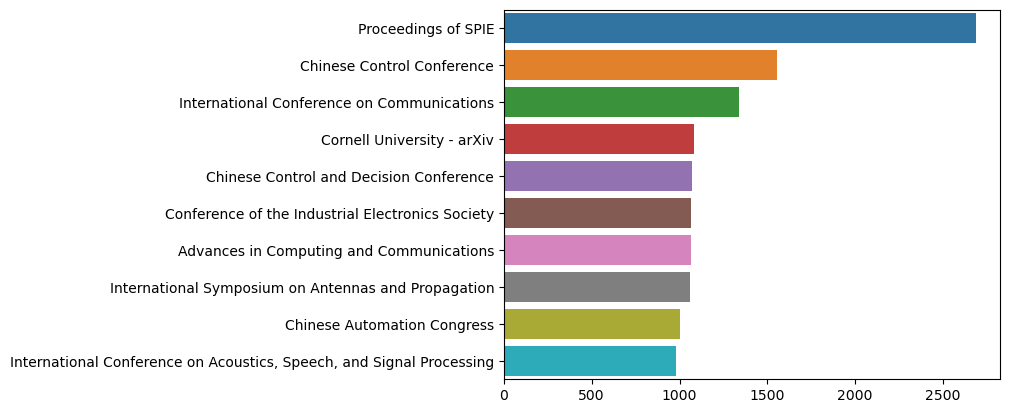

In [7]:
# 0.2. which were top venues producing them?
v = works['host_venue']
v_name = v.map(lambda x: venues.loc[x, 'display_name'])
temp = v_name.value_counts().head(10)

sns.barplot(y=temp.index, x=temp.values)
# -> ICASSP in top-10

<AxesSubplot:>

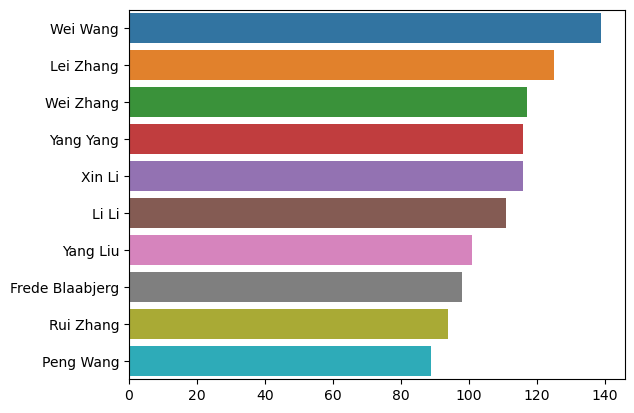

In [8]:
# 0.3. which were top authors producing max works?
a = pd.Series(flatten(works['authorships'].map(firsts)))
a_name = a.map(lambda x: authors.loc[x, 'display_name'])
temp = a_name.value_counts().head(10)

sns.barplot(y=temp.index, x=temp.values)
# -> most top authors from china

<AxesSubplot:>

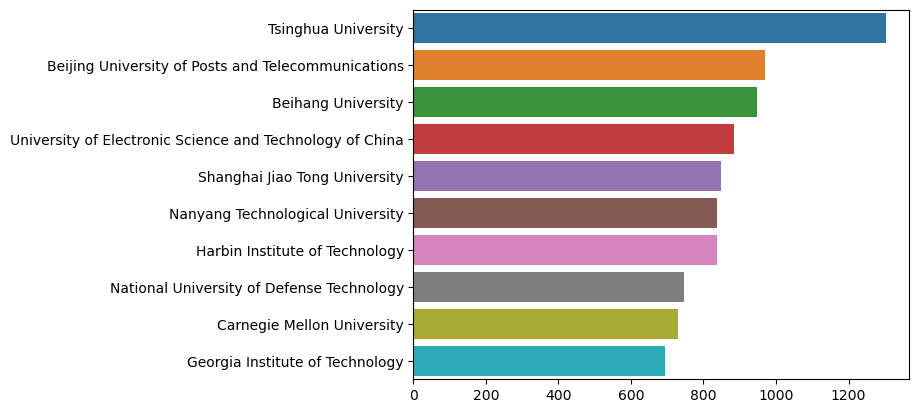

In [9]:
# 0.3. which were top insts producing max works?
ins = pd.Series(flatten(works['authorships'].map(lambda x: set(flatten(lasts(x))))))
ins_name = ins.map(lambda x: insts.loc[x, 'display_name'])
temp = ins_name.value_counts().head(10)

sns.barplot(y=temp.index, x=temp.values)
# -> top insts are chinese origin (CMU and GaTech in top-10)

<AxesSubplot:>

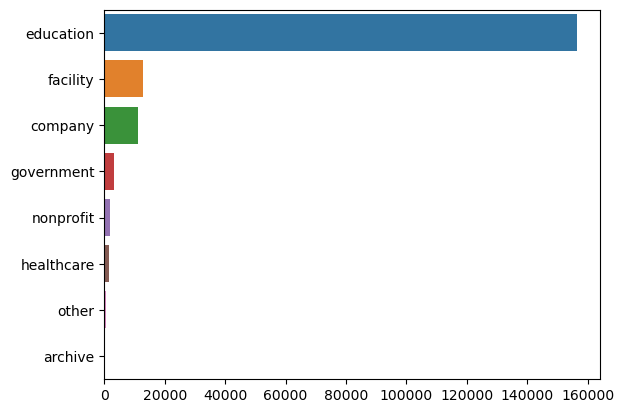

In [10]:
# 0.3.1 which were top insts-sectors producing max works?
ins = pd.Series(flatten(works['authorships'].map(lambda x: set(flatten(lasts(x))))))
ins_name = ins.map(lambda x: insts.loc[x, 'type'])
temp = ins_name.value_counts().head(10)

sns.barplot(y=temp.index, x=temp.values)
# -> most of works are produced by `education` sector

<AxesSubplot:>

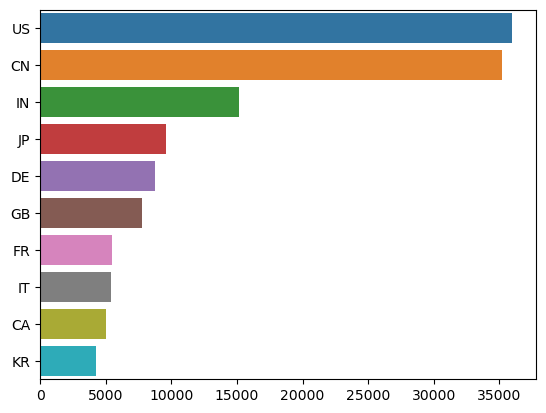

In [11]:
# 0.3.2 which were top insts-countries producing max works?
ins = pd.Series(flatten(works['authorships'].map(lambda x: set(flatten(lasts(x))))))
ins_name = ins.map(lambda x: insts.loc[x, 'country_code'])
temp = ins_name.value_counts().head(10)

sns.barplot(y=temp.index, x=temp.values)
# -> most of works are produced by USA, China and then India

In [13]:
## Works related - eda

In [15]:
# 1.1. which were top 5 concepts produced?
# c = works['concepts'].map(dict)

c = pd.Series(flatten(works['concepts'].map(lambda x: firsts(x))))
c.value_counts().head()
# -> hot topics: CS, AI, Ctrl Theory, C.Networks, CV, etc.
# check here: https://api.openalex.org/<C...>

C41008148     91328
C154945302    16238
C47446073      8833
C31258907      5327
C31972630      5180
dtype: int64

<AxesSubplot:xlabel='month', ylabel='count'>

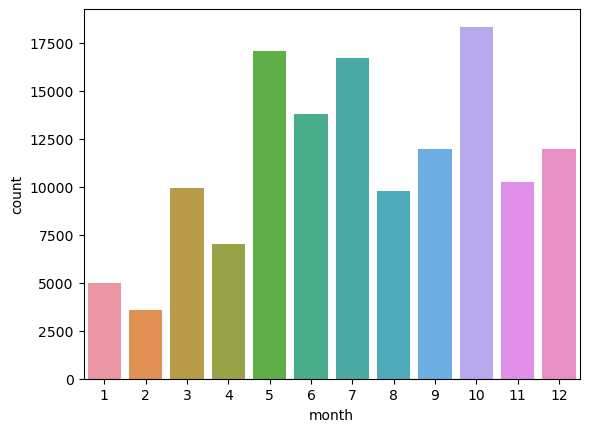

In [16]:
# 1.2. which months noticed max published works?
works['month'] = works['publication_date'].map(lambda x: x.split('-')[1]).astype(int)
sns.countplot(data=works, x='month')
# -> yearly trend

<AxesSubplot:xlabel='open_access_is_oa', ylabel='count'>

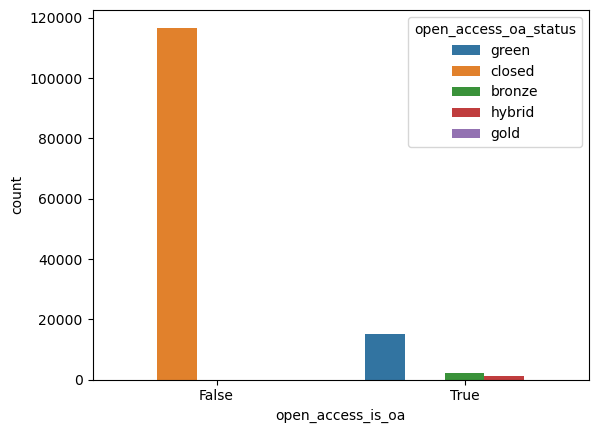

In [17]:
# 1.3. proportion of open-access
sns.countplot(data=works, x='open_access_is_oa', hue='open_access_oa_status')
# -> most of the works are behind the paywall

count    135369.000000
mean          3.593629
std           1.838284
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         100.000000
Name: authorships, dtype: float64

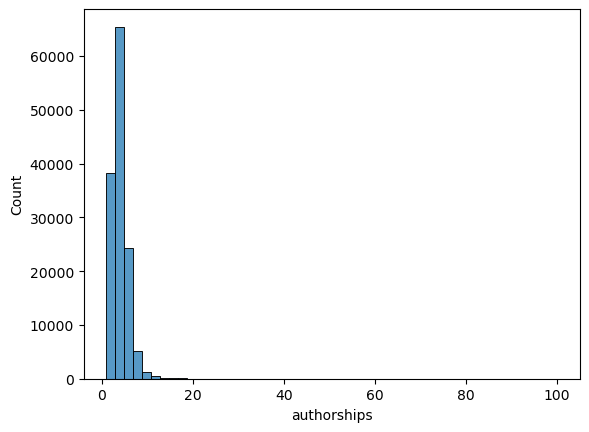

In [18]:
# 1.4. distribution of no. of authors
temp = works['authorships'].map(len)
sns.histplot(temp, bins=50)

temp.describe()
# -> avg of 4 authors per work

count    135369.000000
mean         12.589226
std           8.889528
min           1.000000
25%           6.000000
50%          11.000000
75%          17.000000
max         149.000000
Name: referenced_works, dtype: float64

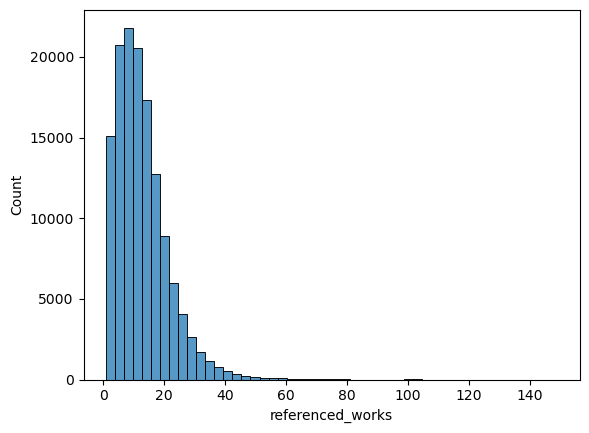

In [19]:
# 1.5. distribution of reference-counts
temp = works['referenced_works'].map(len)
sns.histplot(temp, bins=50)

temp.describe()
# -> avg of 9 references per work

In [36]:
# 1.5. trend of cumulative citations over years
def find_normalized_citation(counts_by_year, year_i, year_0):
    total = [item[1] for item in counts_by_year if item[0] >= year_0]
    till_year_i = [item[1] for item in counts_by_year if item[0] == year_i]
    if len(till_year_i):
        return (np.sum(till_year_i))/(np.sum(total)+0.00001)
    else:
        return 0
    
for year_i in [2017, 2018, 2019, 2020, 2021, 2022]:
    works[f'{year_i-2017}' ] = works['counts_by_year'].map(
        lambda x: find_normalized_citation(x, year_i, YEAR)
    )

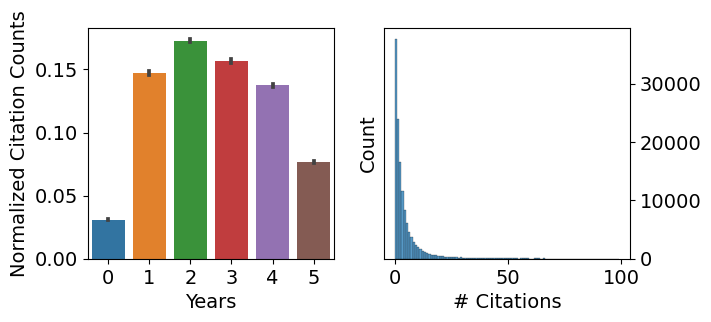

In [40]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(ncols=2, figsize=(7,3))
sns.barplot(data=works[
    [f'{year_i-2017}'  for year_i in [2017, 2018, 2019, 2020, 2021, 2022]]
], ax=ax[0])
ax[0].set_xlabel('Years')
ax[0].set_ylabel('Normalized Citation Counts')

# distribution of citations (~target variable)
sns.histplot(data=works[works['cited_by_count']<100], x='cited_by_count', bins=100, ax=ax[1])
ax[1].yaxis.tick_right()
ax[1].set_xlabel('# Citations')

plt.savefig('log-normal-and-distribution.png', dpi=350, bbox_inches='tight')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

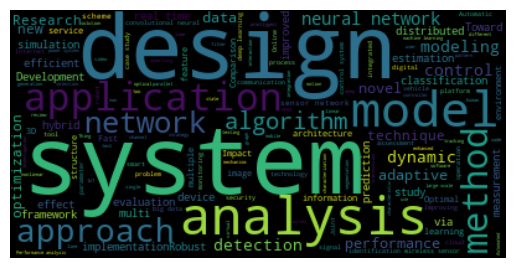

In [41]:
# 1.6. word cloud of concepts, title, abstract

stopwords = set(STOPWORDS)
stopwords.add("using")
stopwords.add("based")

text = ' '.join(works['title'].tolist())

wordcloud = WordCloud(stopwords=stopwords, max_words=1000).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

CPU times: user 26.7 s, sys: 6.72 s, total: 33.4 s
Wall time: 36.3 s


(-0.5, 399.5, 199.5, -0.5)

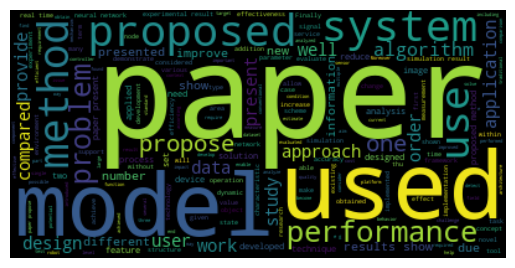

In [25]:
%%time
# 1.6. word cloud of concepts, title, abstract

stopwords = set(STOPWORDS)
stopwords.add("using")
stopwords.add("based")

text = ' '.join(works['abstract'].tolist())

wordcloud = WordCloud(stopwords=stopwords, max_words=1000).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

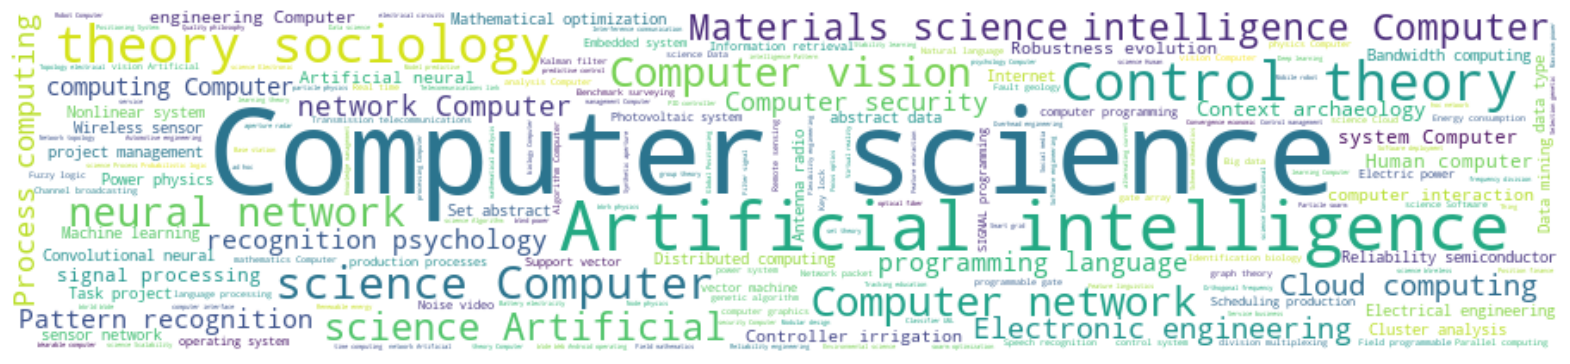

CPU times: user 26.3 s, sys: 3.89 s, total: 30.2 s
Wall time: 32.1 s


In [52]:
%%time
# 1.6. word cloud of concepts


text = ' '.join(flatten(works['concepts'].map(firsts).map(
    lambda x: concepts.loc[x, 'display_name']).tolist()))

wordcloud = WordCloud(stopwords=stopwords, max_words=1000, width=900, height=200, background_color='white').generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('concepts-wordcloud.png', dpi=750, bbox_inches='tight')
plt.show()

In [5]:
concepts.head()

,wikidata,level,description,display_name,works_count,cited_by_count,ancestors,related_concepts,counts_by_year,created_date
id,,,,,,,,,,
C41008148,https://www.wikidata.org/wiki/Q21198,0,theoretical study of the formal foundation ena...,Computer science,76621014,392023223,[],"[[C33923547, 253.91972], [C119599485, 153.0190...","[[2022, 2133974, 26826292], [2021, 2960068, 33...",2016-06-24
C71924100,https://www.wikidata.org/wiki/Q11190,0,"field of study for diagnosing, treating and pr...",Medicine,57585369,579660804,[],"[[C141071460, 104.96226], [C159110408, 79.0236...","[[2022, 1959729, 39938162], [2021, 2639099, 44...",2016-06-24
C86803240,https://www.wikidata.org/wiki/Q420,0,branch of science that primarily deals with st...,Biology,41682391,634777436,[],"[[C185592680, 229.3072], [C121332964, 215.6018...","[[2022, 1460534, 41152010], [2021, 1865725, 46...",2016-06-24
C121332964,https://www.wikidata.org/wiki/Q413,0,"study of matter and its motion, along with rel...",Physics,38272480,395158204,[],"[[C33923547, 476.25504], [C185592680, 380.7751...","[[2022, 1143894, 24239340], [2021, 1569093, 28...",2016-06-24
C17744445,https://www.wikidata.org/wiki/Q36442,0,social science concerned with the study of pol...,Political science,33769362,118588444,[],"[[C144024400, 163.40619], [C162324750, 139.763...","[[2022, 829268, 7986603], [2021, 1413570, 9845...",2016-06-24


### INSTITUTIONS - Global Data

<AxesSubplot:xlabel='works_count', ylabel='type'>

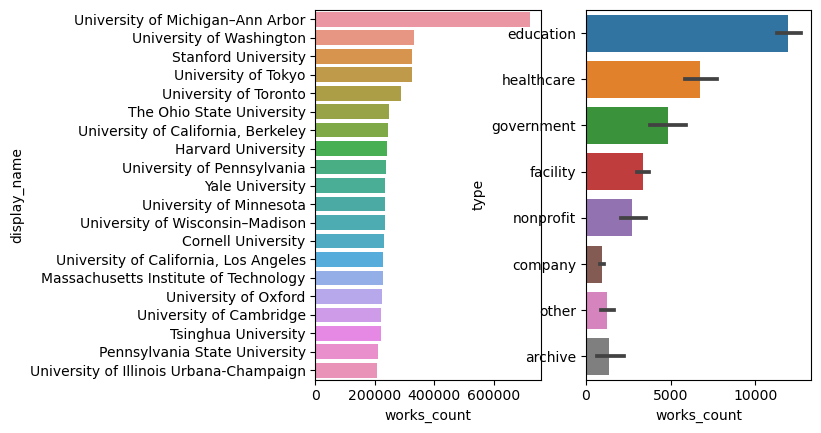

In [28]:
# which are top insts and sectors having highest works
fig, ax = plt.subplots(ncols=2)
temp = insts.sort_values(['works_count', 'cited_by_count'], ascending=False)[:20]
sns.barplot(data=temp, x='works_count', y='display_name', ax=ax[0])

temp = insts.sort_values(['works_count', 'cited_by_count'], ascending=False)
sns.barplot(data=temp, x='works_count', y='type', ax=ax[1])

In [29]:
temp = insts.sort_values(['works_count', 'cited_by_count'], ascending=False)
temp.index.get_loc('I219193219') # `Purdue University West Lafayette`
# -> our university ranks 64

64

<AxesSubplot:xlabel='cited_by_count', ylabel='type'>

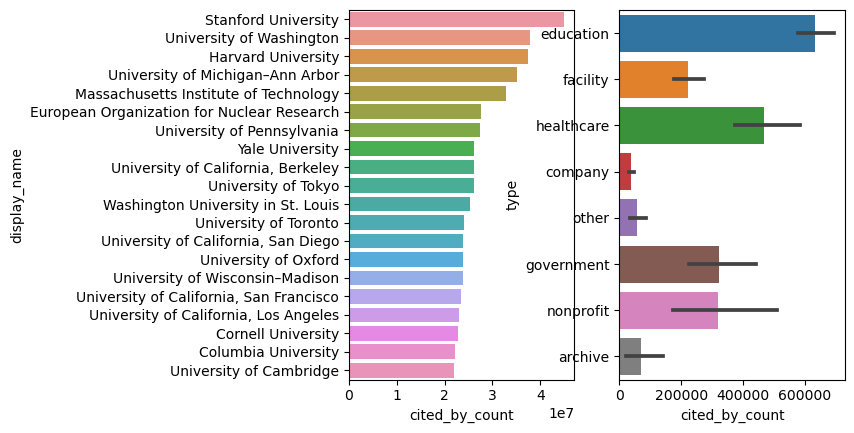

In [30]:
# which are top insts and sectors having highest citations
fig, ax = plt.subplots(ncols=2)
temp = insts.sort_values(['cited_by_count', 'works_count'], ascending=False)[:20]
sns.barplot(data=temp, x='cited_by_count', y='display_name', ax=ax[0])
sns.barplot(data=insts, x='cited_by_count', y='type', ax=ax[1])

<AxesSubplot:xlabel='avg_c_per_w', ylabel='type'>

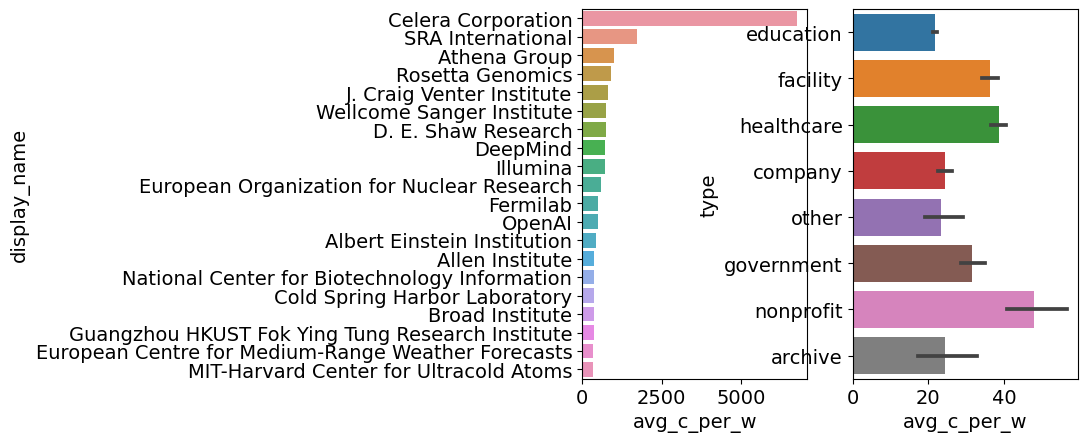

In [20]:
# which are top insts and sectors having highest average citations
insts['avg_c_per_w'] = insts['cited_by_count']/insts['works_count']

fig, ax = plt.subplots(ncols=2)
temp = insts.sort_values(['avg_c_per_w', 'cited_by_count', 'works_count'], ascending=False)[:20]
sns.barplot(data=temp, x='avg_c_per_w', y='display_name', ax=ax[0])
sns.barplot(data=insts, x='avg_c_per_w', y='type', ax=ax[1])

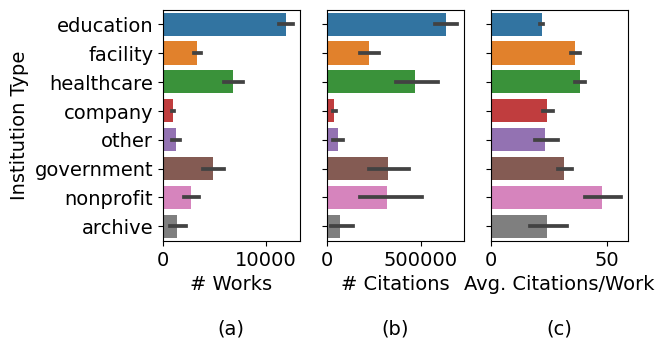

In [30]:
# how insts-sector varies with work, citations, average_citations
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(ncols=3, figsize=(6, 3), sharey=True)
sns.barplot(data=insts, x='works_count', y='type', ax=ax[0])
ax[0].set_ylabel('Institution Type')
ax[0].set_xlabel('# Works\n\n(a)')
sns.barplot(data=insts, x='cited_by_count', y='type', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('# Citations\n\n(b)')
sns.barplot(data=insts, x='avg_c_per_w', y='type', ax=ax[2])
ax[2].set_ylabel('')
ax[2].set_xlabel('Avg. Citations/Work\n\n(c)')

plt.savefig('insts-types.png', dpi=350, bbox_inches='tight')
plt.show()

# -> education sector has high works and citations but low average citations
# -> company/non-profit/archive have low works and citations but higher average citations

### VENUES - Global Data

<AxesSubplot:xlabel='works_count', ylabel='display_name'>

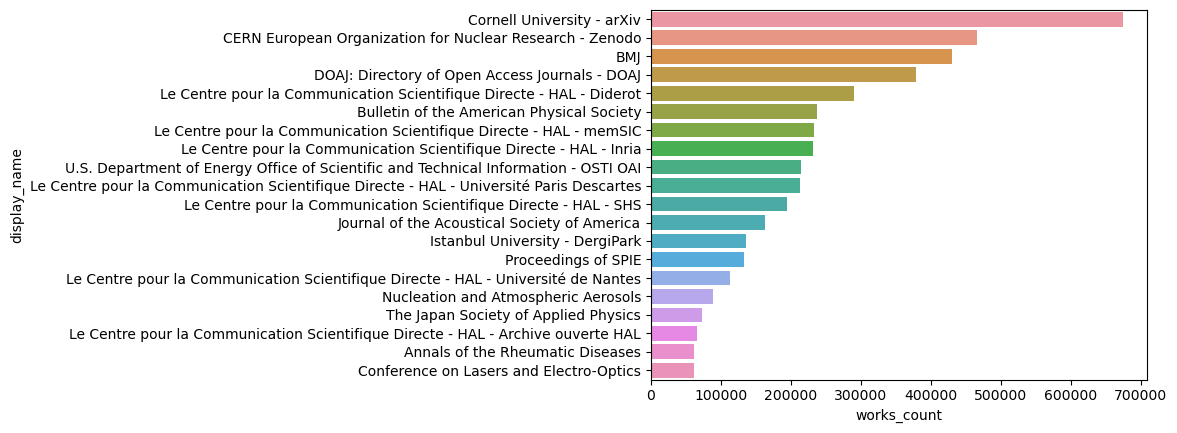

In [33]:
# in general, which venues produce most works
temp = venues.sort_values(['works_count', 'cited_by_count'], ascending=False)[:20]
sns.barplot(data=temp, x='works_count', y='display_name')

<AxesSubplot:xlabel='cited_by_count', ylabel='display_name'>

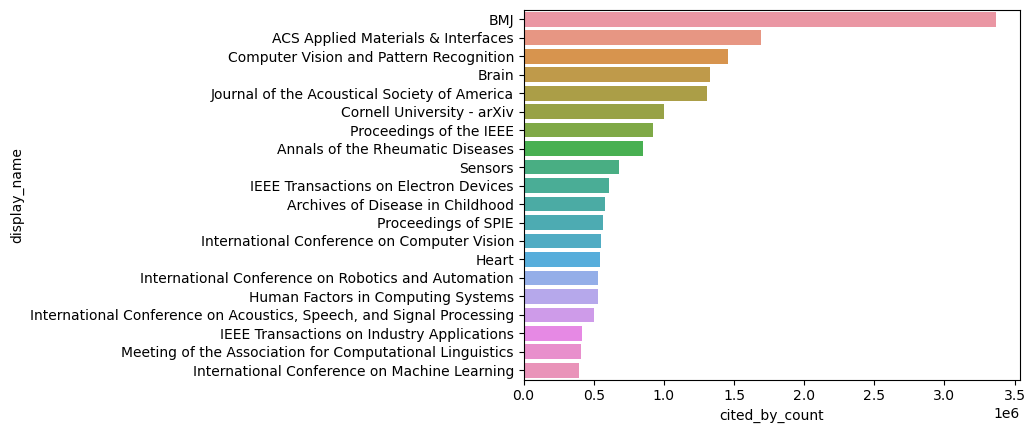

In [34]:
# in general, which venues produce most cited works
temp = venues.sort_values(['cited_by_count', 'works_count'], ascending=False)[:20]
sns.barplot(data=temp, x='cited_by_count', y='display_name')

<AxesSubplot:xlabel='avg_c_per_w', ylabel='display_name'>

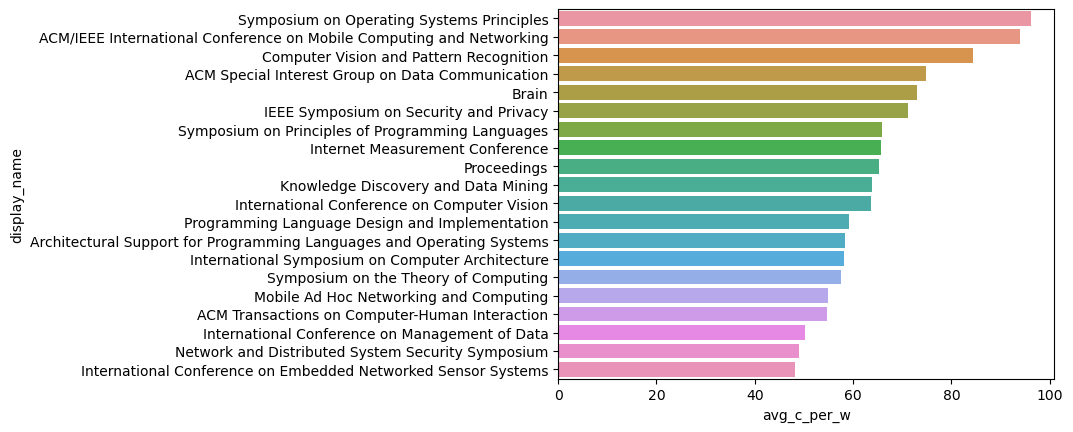

In [35]:
# # in general, which venues produce more citations per work
venues['avg_c_per_w'] = venues['cited_by_count']/venues['works_count']
temp = venues.sort_values(['avg_c_per_w', 'cited_by_count', 'works_count'], ascending=False)[:20]
sns.barplot(data=temp, x='avg_c_per_w', y='display_name')

## Misc

In [36]:
# works counts across train test
total = set(works.index)
train = set(works.iloc[train_index].index)
test = set(works.iloc[test_index].index)
print (f'works: total={len(set(total))}, train={len(train)}, test={len(test)}')

works: total=135369, train=108295, test=27074


In [37]:
# check new authors in test set compared to train
total = set(flatten(works['authorships'].map(firsts)))
train = set(flatten(works.iloc[train_index]['authorships'].map(firsts)))
test = set(flatten(works.iloc[test_index]['authorships'].map(firsts)))
print (f'authors: total={len(set(total))}, train={len(train)}, test={len(test)} (common + new)')
print (f' - common={len(train.intersection(test))}, \n - new in test={len(test.difference(train))}')

authors: total=314743, train=266054, test=84254 (common + new)
 - common=35565, 
 - new in test=48689


In [38]:
# check new institutions in test set compared to train
total = set(flatten(works['authorships'].map(lasts), level=3))
train = set(flatten(works.iloc[train_index]['authorships'].map(lasts), level=3))
test = set(flatten(works.iloc[test_index]['authorships'].map(lasts), level=3))
print (f'institutions: total={len(set(total))}, train={len(train)}, test={len(test)}')
print (f' - common={len(train.intersection(test))}, \n - new in test={len(test.difference(train))}')

institutions: total=13039, train=12022, test=6782
 - common=5765, 
 - new in test=1017


In [39]:
# check new concepts in test set compared to train
total = set(flatten(works['concepts'].map(firsts)))
train = set(flatten(works.iloc[train_index]['concepts'].map(firsts)))
test = set(flatten(works.iloc[test_index]['concepts'].map(firsts)))
print (f'concepts: total={len(set(total))}, train={len(train)}, test={len(test)}')
print (f' - common={len(train.intersection(test))}, \n - new in test={len(test.difference(train))}')

concepts: total=19743, train=18534, test=11409
 - common=10200, 
 - new in test=1209


In [40]:
# check new venues in test set compared to train
total = set(works['host_venue'])
train = set(works.iloc[train_index]['host_venue'])
test = set(works.iloc[test_index]['host_venue'])
print (f'venues: total={len(set(total))}, train={len(train)}, test={len(test)}')
print (f' - common={len(train.intersection(test))}, \n - new in test={len(test.difference(train))}')

venues: total=1745, train=1720, test=1533
 - common=1508, 
 - new in test=25


In [41]:
# referenced works
ref_works = np.unique([j for i in works['referenced_works'].tolist() for j in i])
len(ref_works)

947240

In [42]:
# works in our data
works_in_df = works.index.tolist()
len(works_in_df)

135369

In [43]:
# works in common
len(set(works_in_df).intersection(ref_works))

8281

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

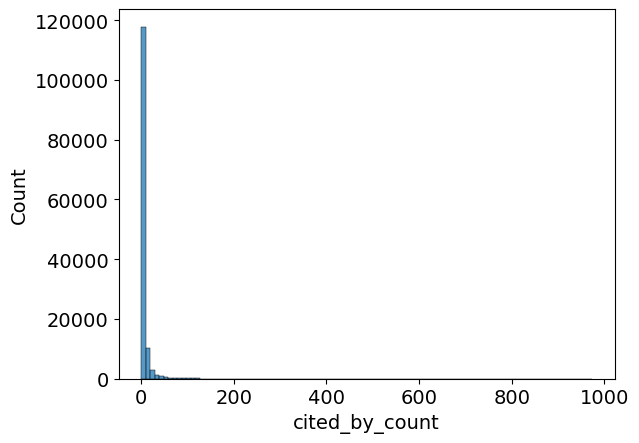

In [31]:
# distribution of citations (~target variable)
sns.histplot(data=works[works['cited_by_count']<100], x='cited_by_count', bins=100)

In [45]:
## Distribution of 2012 CS paper types

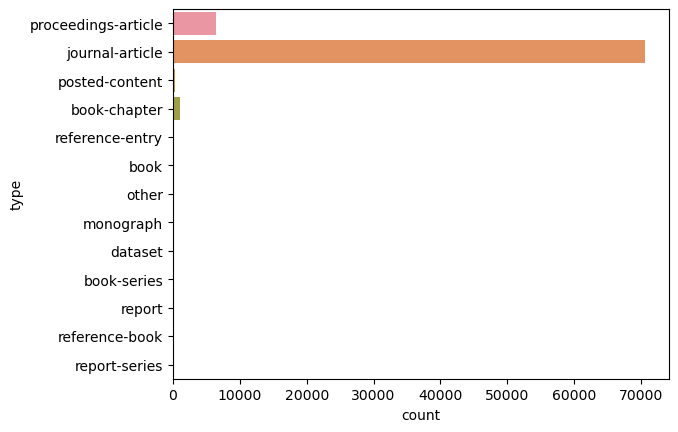

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.37it/s]


Text(0, 0.5, 'Count')

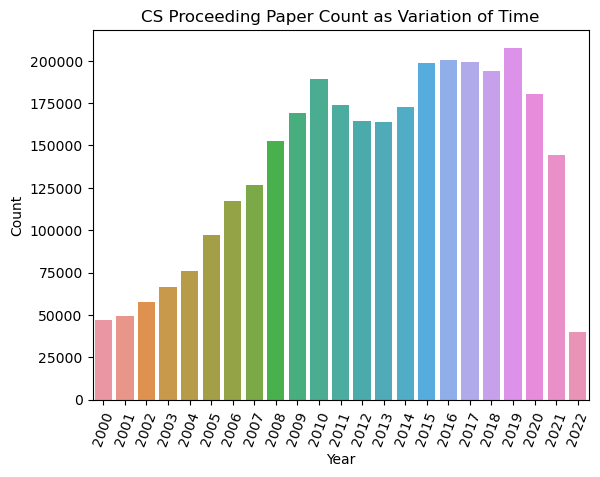

In [17]:
# variation of `proceeding` counts with time
DATA_URL = 'https://api.openalex.org/works?'\
                'filter=from_publication_date:{}-01-01,'\
                'to_publication_date:{}-12-31,'\
                'has_abstract:true,'\
                'has_references:true,'\
                'is_paratext:false,'\
                'is_retracted:false,'\
                'type:proceedings-article,'\
                'concepts.id:C41008148'

papers_over_years = []
years = list(range(2000, 2023))
for year_i in tqdm(years):
    try:
        response = requests.get(DATA_URL.format(year_i, year_i)).json()
        counts = response['meta']['count']
        papers_over_years.append(counts)
    except Exception as err:
        print (err)
        print (response)
        break

sns.barplot(x=years, y=papers_over_years)
plt.gca().set_title("CS Proceeding Paper Count as Variation of Time")
plt.xticks(rotation=70)
plt.gca().set_xlabel("Year")
plt.gca().set_ylabel("Count")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:20<00:00,  1.13it/s]


Text(0, 0.5, 'Count')

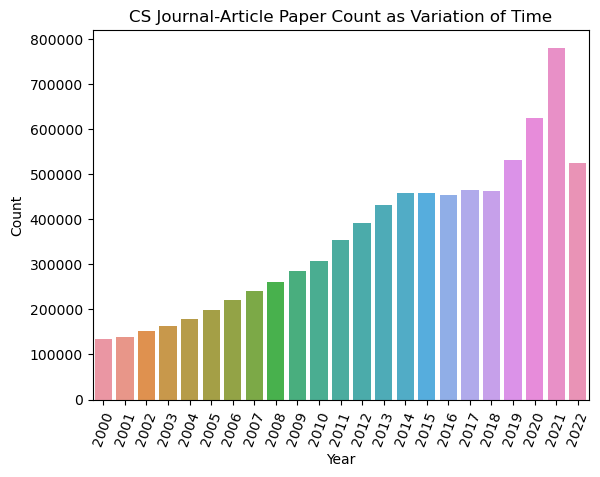

In [18]:
# variation of `journal` counts with time
DATA_URL = 'https://api.openalex.org/works?'\
                'filter=from_publication_date:{}-01-01,'\
                'to_publication_date:{}-12-31,'\
                'has_abstract:true,'\
                'has_references:true,'\
                'is_paratext:false,'\
                'is_retracted:false,'\
                'type:journal-article,'\
                'concepts.id:C41008148'

papers_over_years = []
years = list(range(2000, 2023))
for year_i in tqdm(years):
    try:
        response = requests.get(DATA_URL.format(year_i, year_i)).json()
        counts = response['meta']['count']
        papers_over_years.append(counts)
    except Exception as err:
        print (err)
        print (response)
        break

sns.barplot(x=years, y=papers_over_years)
plt.xticks(rotation=70)
plt.gca().set_title("CS Journal-Article Paper Count as Variation of Time")
plt.gca().set_xlabel("Year")
plt.gca().set_ylabel("Count")

## ROUGH

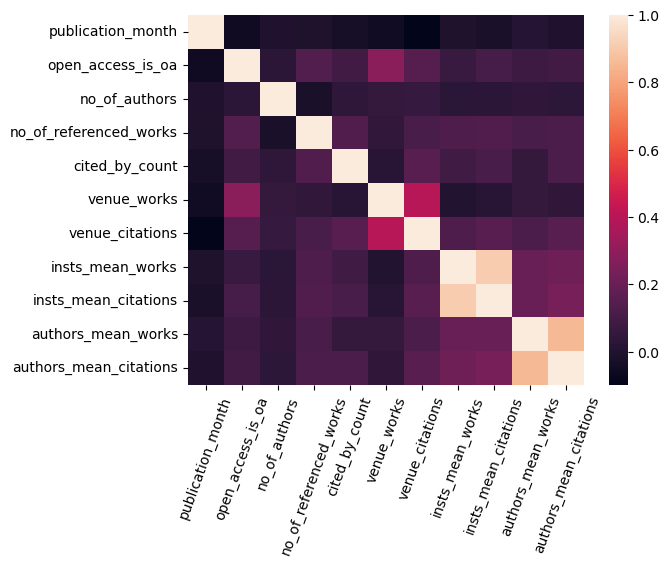

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('./data/data2012.csv')

corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.savefig('corr.png', dpi=350, bbox_inches='tight')
# plt.xticks(rotation=70)
plt.show()

In [38]:
authors['created_date'].map(lambda x: int(x.split('-')[0])).value_counts()

2016    160160
2017    114054
2018     47949
2021      8362
2019      8319
2020      5624
2022         2
Name: created_date, dtype: int64

In [36]:
venues['type'].value_counts()

conference    1358
journal        439
repository      57
Name: type, dtype: int64

In [14]:
# top-k venues: based on works published in YEAR=2017
works['host_venue'].map(lambda x: venues.loc[x, 'display_name']).value_counts().head()

Proceedings of SPIE                           2699
Chinese Control Conference                    1565
International Conference on Communications    1351
Cornell University - arXiv                    1173
Chinese Control and Decision Conference       1075
Name: host_venue, dtype: int64